# Topic Prior Regularizer Tutorial 

The notebook contains the application and impact of `TopicPriorRegularizer` and its version with sampling a priori probabilities $\varphi_t$ from the Dirichlet distribution.

---

# Пример работы с TopicPriorRegularizer.

В ноутбуке рассматривается применение и влияние на тематические модели регуляризатора `TopicPriorRegularizer` и его версии с семплированием априорных вероятностей $\varphi_t$ из распределения Дирихле.

# Contents<a id="contents"></a>

* [Formula](#formula)
* [Data Loading](#data-loading)
* [Model Training](#model-training)
* [Looging at the Models](#exploring-models)
    * [Plots](#plots)
    * [Viewers](#viewers)
* [Semantic Radius Score Computation](#semantic-radius-score)

In [1]:
import numpy as np
import pandas as pd

from numpy import random
from matplotlib import pyplot as plt

In [2]:
import artm

from topicnet.cooking_machine.dataset import Dataset

from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.models.semantic_radius_score import SemanticRadiusScore
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorRegularizer
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorSampledRegularizer

from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

## Formula<a id="formula"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

$$R(\Phi,\Theta) = \sum_t\sum_w\beta_t\ln\phi_{wt}$$
$$\frac{\partial R}{\partial\Phi_{wt}} = \frac{\beta_t}{\varphi_{wt}}$$

## Data Loading<a id="data-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

The collection to be used for modeling contains 1000 documents on the topic "Business" and 100 documents on the topic "Music".

In [3]:
DATA_PATH = 'data/lenta_1000_100.csv'

dataset_lenta = Dataset(DATA_PATH, batch_size=10)
dictionary_lenta = dataset_lenta.get_dictionary()
batch_vectorizer_lenta = dataset_lenta.get_batch_vectorizer()

In [4]:
pd.read_csv(DATA_PATH).groupby('tags').count()['id']

tags
Бизнес    1000
Музыка     100
Name: id, dtype: int64

## Model Training<a id="model-training"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

With 2 topics

In [5]:
pd.read_csv('data/lenta_1000_100.csv').groupby('tags').count()

,Unnamed: 0,Unnamed: 0.1,url,title,text,topic,id,raw_lemmatized,lemmatized,ngramms,vw_text
tags,,,,,,,,,,,
Бизнес,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
Музыка,100,100,100,100,100,100,100,100,100,100,100


In [6]:
topic_prior_reg = TopicPriorRegularizer(name='topic_prior', tau=5, num_topics=2, beta=[10, 1])

In [7]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

In [8]:
topic_model_lenta = TopicModel(artm_model=model_lenta, model_id='model_lenta')
topic_model_lenta_unbalanced = TopicModel(artm_model=model_lenta_unbalanced, model_id='model_lenta_unbalanced')

In [9]:
topic_model_lenta._fit(batch_vectorizer_lenta, 10, custom_regularizers={topic_prior_reg.name: topic_prior_reg})

topic_model_lenta_unbalanced._fit(batch_vectorizer_lenta, 10)

## Looging at the Models<a id="exploring-models"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [10]:
print('Balance of documents in a model WITH a regularizer:\n{}\n'.format(
    topic_model_lenta.get_theta().idxmax().value_counts()
))

print('Balance of documents in a model WITHOUT a regularizer:\n{}'.format(
    topic_model_lenta_unbalanced.get_theta().idxmax().value_counts()
))

Balance of documents in a model WITH a regularizer:
topic_1    1048
topic_0      52
dtype: int64

Balance of documents in a model WITHOUT a regularizer:
topic_0    634
topic_1    466
dtype: int64


### Plots<a id="plots"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

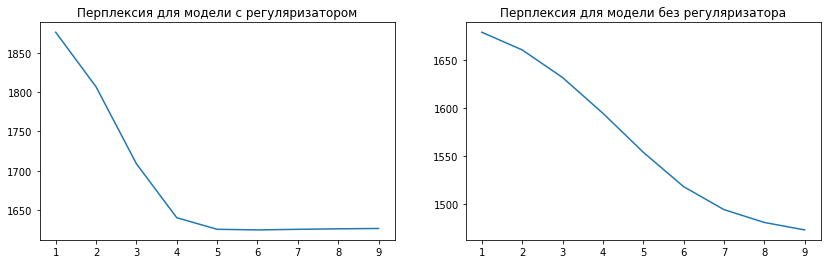

In [11]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity for the model WITH a regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity for the model WITHOUT a regularizer')
plt.plot(values)

### Viewers<a id="viewers"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Top-tokens for models' topics:

In [12]:
tokens_viewer = TopTokensViewer(model=topic_model_lenta, num_top_tokens=10)
top_tokens_dict = tokens_viewer.view()
    
for topic_id, topic in enumerate(top_tokens_dict.values()):
    print('Topic {}:\n\nTop ngramms: {}\n\nTop words: {}\n\n'.format(
        str(topic_id), ', '.join(topic['ngramms'].keys()), ', '.join(topic['text'].keys())
         ))

Topic 0:

Top ngramms: рок_группа, студийный_альбом, лидер_группа, <person>_бибер, музыкант_<person>_<person>, причина_смерть, певица_<person>, джей_зи, музыкальный_премия, ляпис_<person>

Top words: альбом, музыкант, певица, песня, концерт, музыкальный, фестиваль, артист, песнь, выступление


Topic 1:

Top ngramms: <person>_<person>, миллиард_рубль, миллиард_доллар, миллион_доллар, процент_акция, пресс_релиз, миллион_рубль, российский_компания, прошлое_год, генеральный_директор

Top words: ., <person>, год, компания, что, В, быть, процент, миллиард, рубль




In [13]:
tokens_viewer_unbalanced = TopTokensViewer(model=topic_model_lenta_unbalanced, num_top_tokens=10)
top_tokens_dict_unbalanced = tokens_viewer_unbalanced.view()
    
for topic_id, topic in enumerate(top_tokens_dict_unbalanced.values()):
    print('Topic {}:\n\nTop ngramms: {}\n\nTop words: {}\n\n'.format(
        str(topic_id), ', '.join(topic['ngramms'].keys()), ', '.join(topic['text'].keys())
         ))

Topic 0:

Top ngramms: миллиард_рубль, <person>_<person>, миллиард_доллар, миллион_доллар, процент_акция, миллион_рубль, пресс_релиз, совет_директор, ценный_бумага, прошлое_год

Top words: ., <person>, год, компания, что, процент, В, быть, миллиард, рубль


Topic 1:

Top ngramms: <person>_<person>, пресс_релиз, миллиард_кубометр, пресс_служба, российский_компания, тысяча_рубль, турецкий_поток, миллиард_доллар, миллион_рубль, санкт_петербург

Top words: ., <person>, что, год, быть, В, компания, российский, россия, газпром




## Semantic Radius Score Computation<a id="semantic-radius-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

* Source file: [semantic_radius_score.py](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/cooking_machine/models/semantic_radius_score.py)

In [14]:
# Computing the radii of semantic homogeneity takes time!

score = SemanticRadiusScore(batch_vectorizer=batch_vectorizer_lenta)

In [15]:
%%time

score.call(topic_model_lenta)

CPU times: user 3min 13s, sys: 46 s, total: 3min 59s
Wall time: 2min 33s


[115.3279217051616, 850.0191702090277]

In [16]:
%%time

score.call(topic_model_lenta_unbalanced)

CPU times: user 2min 50s, sys: 44.2 s, total: 3min 34s
Wall time: 2min 11s


[574.0395802870606, 448.1119428664679]